In [528]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import pickle
%matplotlib inline

In [529]:
def calibrate():
    chessboard_list = os.listdir("./camera_cal")
    nx = 9
    ny = 6

    objpoints = []
    imgpoints = []

    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    for chessboard in chessboard_list:

        img = cv2.imread("./camera_cal/" + chessboard)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    calibration_parameters = {}
    calibration_parameters["mtx"] = mtx
    calibration_parameters["dist"] = dist
    pickle.dump(calibration_parameters, open("calibration.p", "wb"))
    return mtx, dist

In [530]:
def undistort(image, mtx, dist):
    undist = cv2.undistort(image, mtx,
                            dist, None,
                            mtx)
    return undist

In [531]:
def perspective_transform(image, source_points, destination_points):
    M = cv2.getPerspectiveTransform(source_points, destination_points)
    Minv = cv2.getPerspectiveTransform(destination_points, source_points)
    warped = cv2.warpPerspective(image, M, (1280, 720), flags=cv2.INTER_LINEAR)

    return warped, Minv

In [532]:
mtx, dist = calibrate()

In [533]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient == 'x':
        sobel = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient == 'y':
        sobel = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled)
    grad_binary[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    return grad_binary

def mag_thresh(image, sobel_kernel=3, thresh=(0, 255)):
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    magnitude = np.sqrt(sobelx**2 +  sobely**2)
    scaled = np.uint8(255*magnitude/np.max(magnitude))
    mag_binary = np.zeros_like(scaled)
    mag_binary[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    return mag_binary

def dir_thresh(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary = np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return dir_binary

def color_thresh(image, thresh=(0, 255)):
    color_binary = np.zeros_like(image)
    color_binary[(image >= thresh[0]) & (image <= thresh[1])] = 1
    return color_binary

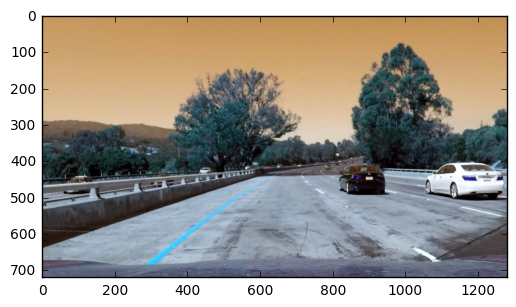

In [534]:
image = cv2.imread('./test_images/test1.jpg')
image = cv2.GaussianBlur(image, (5, 5), 0)
plt.imshow(image)

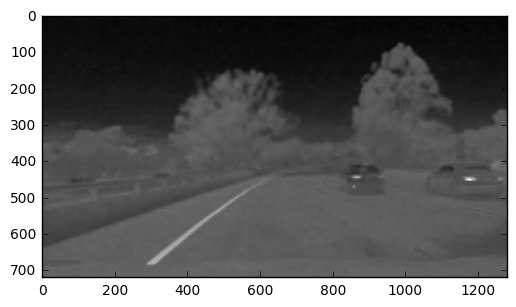

In [535]:
hls_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
yuv_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
plt.imshow(yuv_image[:,:,1], cmap='gray')

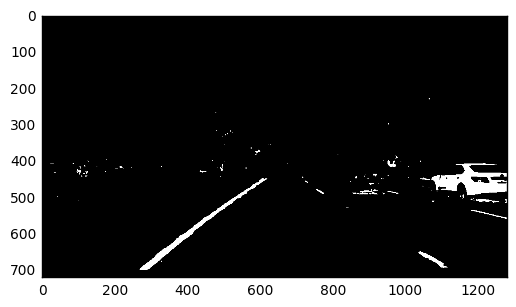

In [536]:
s = undistort(hls_image[:,:,2], mtx, dist)
r = undistort(image[:,:,2], mtx, dist)
u = undistort(yuv_image[:,:,1], mtx, dist)

s_binary = color_thresh(s, (200, 255))
u_binary = color_thresh(r, (220, 255))

sr_combined = np.zeros_like(s_binary)
sr_combined[(s_binary == 1) | (u_binary == 1)] = 1

plt.imshow(sr_combined, cmap='gray')

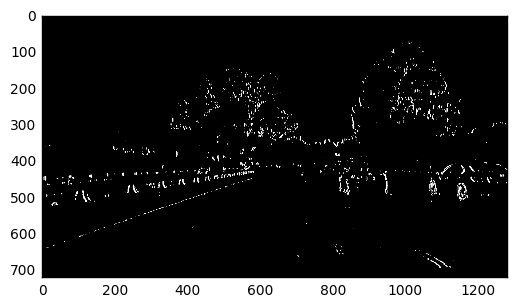

In [537]:
x_binary = abs_sobel_thresh(r, 'x', 3, (50, 160))
plt.imshow(x_binary, cmap='gray')

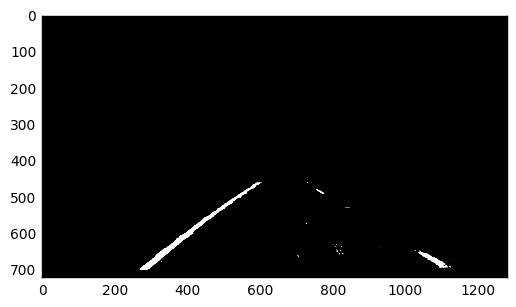

In [538]:
combined_all = np.zeros_like(sr_combined)
combined_all[(sr_combined == 1) | (x_binary == 1)] = 1

vertices = np.array([[(570, 460), (200, 720), (1240, 720), (760, 460)]])
mask = np.zeros_like(combined_all)
cv2.fillPoly(mask, vertices, 255)
combined_all = cv2.bitwise_and(combined_all, mask)

plt.imshow(combined_all, cmap='gray')

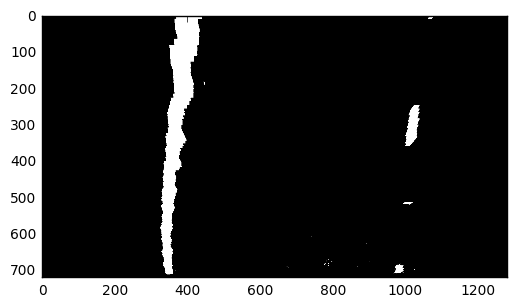

In [539]:
source_points = np.float32([[579, 460], [210, 720], [1128, 720], [706, 460]])
destination_points = np.float32([[320, 0], [320, 720], [960, 720], [960, 0]])

warped, Minv = perspective_transform(combined_all, source_points, destination_points)
plt.imshow(warped, cmap='gray')

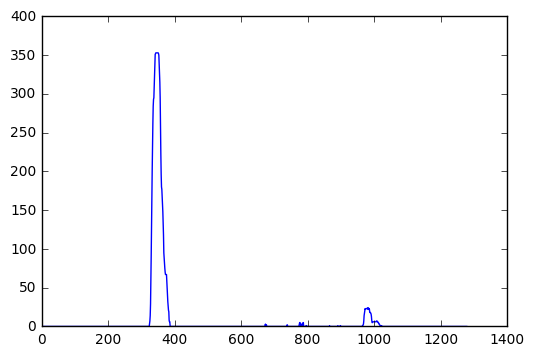

In [540]:
hist = np.sum(warped[warped.shape[0]//2:, :], axis=0)
plt.plot(hist)

In [541]:
left_peak = np.argmax(hist[:warped.shape[1]//2])
right_peak = np.argmax(hist[warped.shape[1]//2:]) + warped.shape[1]//2

out_img = np.dstack((warped, warped, warped))*255

In [542]:
print(left_peak)
print(right_peak)

343
980


In [543]:
nwindows = 9
window_height = warped.shape[0] // nwindows

nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

leftx_current = left_peak
rightx_current = right_peak

margin = 100
minpix = 50

left_lane_inds = []
right_lane_inds = []


# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = warped.shape[0] - (window+1)*window_height
    win_y_high = warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

720


(720, 0)

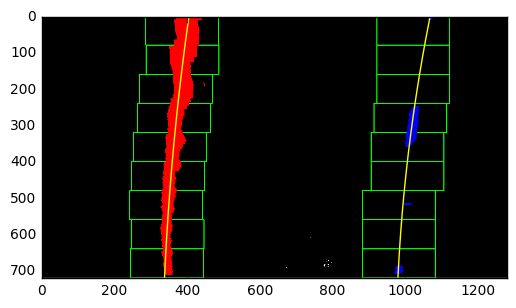

In [544]:
# Generate x and y values for plotting
fity = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
fit_leftx = left_fit[0]*fity**2 + left_fit[1]*fity + left_fit[2]
fit_rightx = right_fit[0]*fity**2 + right_fit[1]*fity + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(fit_leftx, fity, color='yellow')
plt.plot(fit_rightx, fity, color='yellow')
print(warped.shape[0])
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 1280, 3)
[[  1.98437500e-01  -7.63816267e-01   5.15500000e+02]
 [ -2.22044605e-16  -5.00544662e-01   4.60000000e+02]
 [ -4.33680869e-18  -1.19674413e-03   1.00000000e+00]]


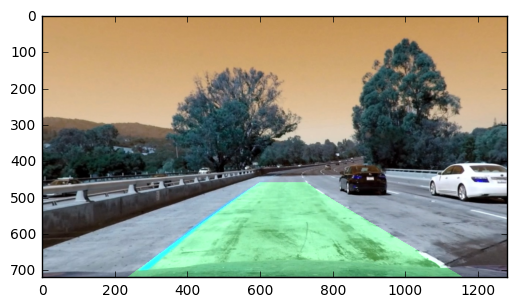

In [545]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)

color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
print(color_warp.shape)
undist = undistort(image, mtx, dist)
# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([fit_leftx, fity]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([fit_rightx, fity])))])
pts = np.hstack((pts_left, pts_right))
print(Minv)
# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (1280, 720)) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)

In [546]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import pickle
%matplotlib inline

In [547]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [548]:
def calibrate():
    chessboard_list = os.listdir("./camera_cal")
    nx = 9
    ny = 6

    objpoints = []
    imgpoints = []

    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    for chessboard in chessboard_list:

        img = cv2.imread("./camera_cal/" + chessboard)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    calibration_parameters = {}
    calibration_parameters["mtx"] = mtx
    calibration_parameters["dist"] = dist
    pickle.dump(calibration_parameters, open("calibration.p", "wb"))
    return mtx, dist

In [549]:
def undistort(image, mtx, dist):
    undist = cv2.undistort(image, mtx,
                            dist, None,
                            mtx)
    return undist

In [550]:
def perspective_transform(image, source_points, destination_points):
    M = cv2.getPerspectiveTransform(source_points, destination_points)
    Minv = cv2.getPerspectiveTransform(destination_points, source_points)
    warped = cv2.warpPerspective(image, M, (1280, 720), flags=cv2.INTER_LINEAR)

    return warped, Minv

In [551]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient == 'x':
        sobel = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient == 'y':
        sobel = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled)
    grad_binary[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    return grad_binary

def mag_thresh(image, sobel_kernel=3, thresh=(0, 255)):
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    magnitude = np.sqrt(sobelx**2 +  sobely**2)
    scaled = np.uint8(255*magnitude/np.max(magnitude))
    mag_binary = np.zeros_like(scaled)
    mag_binary[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    return mag_binary

def dir_thresh(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary = np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return dir_binary

def color_thresh(image, thresh=(0, 255)):
    color_binary = np.zeros_like(image)
    color_binary[(image >= thresh[0]) & (image <= thresh[1])] = 1
    return color_binary

In [552]:
# Container class for geometrical parameters
class Parameters:
    def __init__(self):
        # Calibration parameters
        self.mtx = None
        self.dst = None
        # Perspective transform parameters
        self.M = None
        self.Minv = None
        self.warped_shape = None
        # Masking parameter
        self.vertices = None
        self.mask = None

In [553]:
class Line():
    def __init__(self):
        # Maximum of the buffer
        self.limit = 40
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None 
        #polynomial coefficients of the last n fits of the line
        self.recent_fits = []
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])] 
        #polynomial coefficients for the most recent metric fit
        self.current_metric_fit = [np.array([False])]
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        # Current peak of histogram
        self.peak = None
        # Recent peaks of histogram
        self.recent_peaks = []
        # Average of the peaks
        self.best_peak = None
        # Lane indices
        self.line_inds = []
        # Current lane indices
        self.current_line_inds = None
        
    def update_fit(self, values, metric_values):
        self.recent_fits.append(values)
        self.current_fit = values
        if len(self.recent_fits) > self.limit:
            self.recent_fits = self.recent_fits[1:]
        
        self.best_fit = np.mean(self.recent_fits, axis=0)
        self.current_metric_fit = metric_values
    
    def update_peak(self, value):
        self.peak = value
        self.recent_peaks.append(value)
        if len(self.recent_peaks) > self.limit:
            self.recent_peaks = self.recent_peaks[1:]
        self.best_peak = np.mean(self.recent_peaks, axis=0)

In [554]:
left_line = Line()
right_line = Line()

In [555]:
parameters = Parameters()
parameters.mtx, parameters.dst = calibrate()
parameters.image_size = (1280, 720)

In [556]:
def process_image(image):
    image = cv2.GaussianBlur(image, (5, 5), 0)
    hls_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    s = undistort(hls_image[:,:,2], parameters.mtx, parameters.dst)
    r = undistort(image[:,:,2], parameters.mtx, parameters.dst)

    s_binary = color_thresh(s, (100, 255))
    r_binary = color_thresh(r, (100, 255))

    sr_combined = np.zeros_like(s_binary)
    sr_combined[(s_binary == 1) & (r_binary == 1)] = 1
    x_binary = abs_sobel_thresh(r, 'x', 3, (30, 150))
    
    combined_all = np.zeros_like(sr_combined)
    
    combined_all[(sr_combined == 1) | (x_binary == 1)] = 1
    
    vertices = np.array([[(570, 460), (200, 720), (1240, 720), (740, 460)]])
    mask = np.zeros_like(combined_all)
    cv2.fillPoly(mask, vertices, 255)
    combined_all = cv2.bitwise_and(combined_all, mask)


    source_points = np.float32([[582, 460], [210, 720], [1128, 720], [704, 460]])
    destination_points = np.float32([[320, 0], [320, 720], [960, 720], [960, 0]])

    warped, parameters.Minv = perspective_transform(combined_all, source_points, destination_points)
    
    return warped

In [557]:
def set_base_peak(warped):
    hist = np.sum(warped[720//2:, :], axis=0)
    
    left_line.update_peak(np.argmax(hist[:1280//2]))
    right_line.update_peak(np.argmax(hist[1280//2:]) + 1280//2)

In [558]:
def search_in_frame(warped, nonzerox, nonzeroy):
    nwindows = 9
    window_height = warped.shape[0] // nwindows

    leftx_current = left_line.peak
    rightx_current = right_line.peak

    margin = 100
    minpix = 50

    left_lane_inds = []
    right_lane_inds = []


    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    return left_lane_inds, right_lane_inds

In [559]:
def search_in_margin(image, nonzerox, nonzeroy):
    margin = 100
    left_line_inds = ((nonzerox > (left_line.current_fit[0]*(nonzeroy**2) 
                                   + left_line.current_fit[1]*nonzeroy 
                                   + left_line.current_fit[2] - margin)) 
                      & (nonzerox < (left_line.current_fit[0]*(nonzeroy**2) 
                                     + left_line.current_fit[1]*nonzeroy 
                                     + left_line.current_fit[2] + margin))).nonzero()[0]
    right_line_inds = ((nonzerox > (right_line.current_fit[0]*(nonzeroy**2) 
                                    + right_line.current_fit[1]*nonzeroy 
                                    + right_line.current_fit[2] - margin)) 
                       & (nonzerox < (right_line.current_fit[0]*(nonzeroy**2) 
                                      + right_line.current_fit[1]*nonzeroy 
                                      + right_line.current_fit[2] + margin))).nonzero()[0]
    
    return left_line_inds, right_line_inds

In [560]:
def calculate_metrics(line):
    
    fit = np.polyfit(line.ally, line.allx, 2)
    
    # Fit second order polynomial with real world values
    ym_per_pix = 30 / 720
    xm_per_pix = 3.7 / 700
    y_eval = np.max(line.ally)*ym_per_pix
    
    fit_real = np.polyfit(line.ally*ym_per_pix, line.allx*xm_per_pix, 2)
    
    
    # Update fits of the lines
    line.update_fit(fit, fit_real)
    
    # Generate x and y values for plotting
    fity = np.linspace(0, 719, 720)
    fit_leftx = line.best_fit[0]*fity**2 + line.best_fit[1]*fity + line.best_fit[2]
    
    # Find the curve radii
    line.radius_of_curvature = ((1 + (2*fit_real[0]*y_eval*ym_per_pix + fit_real[1])**2)**1.5) \
                             /np.absolute(2*fit_real[0])

In [561]:
def visualize(image, warped):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    undist = undistort(image, parameters.mtx, parameters.dst)
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_line.allx, left_line.ally]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.allx, right_line.ally])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, parameters.Minv, (1280, 720)) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    # Display values
    curverad = (left_line.radius_of_curvature + right_line.radius_of_curvature) / 2
    lane_offset = (left_line.line_base_pos + right_line.line_base_pos) / 2
    result = cv2.putText(result, str(curverad), (200, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 4)
    result = cv2.putText(result, str(lane_offset), (200, 300), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 4)
    return result

In [562]:
def pipeline(image):
    check = False
    # Undistorting, filtering and perspective transform
    warped = process_image(image)

    # For visualization
    out_img = np.dstack((warped, warped, warped))*255
    
    # Identifying nonzero x and y pixels
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Finding basis histogram peaks
    set_base_peak(warped)
    
    left_line_inds = []
    right_line_inds = []
    
    # Sliding windows search, in frame or in small margin
    if (left_line.detected and right_line.detected):
        left_line_inds, right_line_inds = search_in_margin(image, nonzerox, nonzeroy)
    else:
        left_line_inds, right_line_inds = search_in_frame(image, nonzerox, nonzeroy)
        
    left_line.detected = False
    right_line.detected = False
    
    if len(left_line_inds) > 0 and len(right_line_inds) > 0:
        
        left_line.allx = nonzerox[left_line_inds]
        right_line.allx = nonzerox[right_line_inds]
        left_line.ally = nonzeroy[left_line_inds]
        right_line.ally = nonzeroy[right_line_inds]
        
        if len(left_line.ally) > 0  and len(left_line.allx) > 0:
            left_line.detected = True
            calculate_metrics(left_line)
        if len(right_line.ally) > 0  and len(right_line.allx) > 0:
            right_line.detected = True
            calculate_metrics(right_line)
        check = True
    left_line.line_base_pos = abs(left_line.best_peak - parameters.image_size[0] / 4)
    right_line.line_base_pos = abs(right_line.best_peak - 3 * parameters.image_size[0] / 4)
    
    result = visualize(image, warped)
    
    return result

In [563]:
video_output = "output1.mp4"
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(pipeline)
%time clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output1.mp4
[MoviePy] Writing video output1.mp4





































  0%|          | 0/1261 [00:00<?, ?it/s]


































  0%|          | 1/1261 [00:00<03:41,  5.69it/s]


































  0%|          | 2/1261 [00:00<03:48,  5.50it/s]


































  0%|          | 3/1261 [00:00<03:39,  5.73it/s]


































  0%|          | 4/1261 [00:00<03:29,  6.01it/s]


































  0%|          | 5/1261 [00:00<03:21,  6.24it/s]


































  0%|          | 6/1261 [00:00<03:14,  6.46it/s]


































  1%|          | 7/1261 [00:01<03:11,  6.56it/s]


































  1%|          | 8/1261 [00:01<03:08,  6.66it/s]


































  1%|          | 9/1261 [00:01<03:17,  6.33it/s]


































  1%|          | 10/1261 [00:01<03:36,  5.79it/s]


































  1%|          | 11/1261 [00:01<03:36,  5.78it/s]











[MoviePy] Done.
[MoviePy] >>>> Video ready: output1.mp4 

CPU times: user 8min 42s, sys: 42 s, total: 9min 24s
Wall time: 3min 39s


In [564]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))